In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [7]:
#load the data 
data = pd.read_csv('./wine.csv')

EXPLORATORY DATA ANALYSIS

In [10]:
#shape of data
data.shape

(6497, 13)

In [12]:
#features in data
data.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [14]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [16]:
#checking the missing data
data.isnull().any().any()

True

In [18]:
# Fill or drop missing values  
data = data.dropna()  

In [20]:
for col in data.columns.values:
    print("Number of unique values of {} : {}".format(col, data[col].nunique()))

Number of unique values of type : 2
Number of unique values of fixed acidity : 106
Number of unique values of volatile acidity : 187
Number of unique values of citric acid : 89
Number of unique values of residual sugar : 315
Number of unique values of chlorides : 214
Number of unique values of free sulfur dioxide : 135
Number of unique values of total sulfur dioxide : 276
Number of unique values of density : 996
Number of unique values of pH : 108
Number of unique values of sulphates : 111
Number of unique values of alcohol : 111
Number of unique values of quality : 7


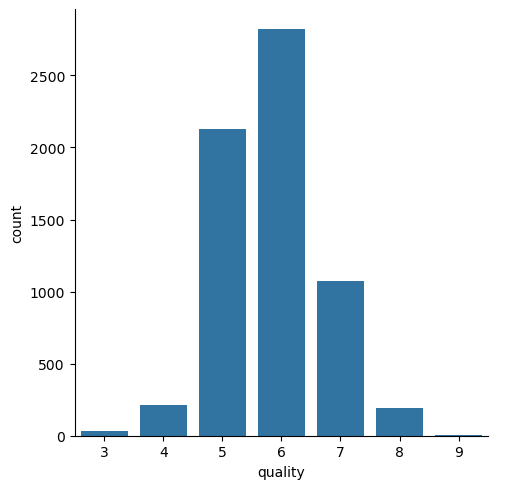

In [23]:
#show the relationship between a numerical and one or more categorical variables
sns.catplot(x="quality", data=data, kind='count')

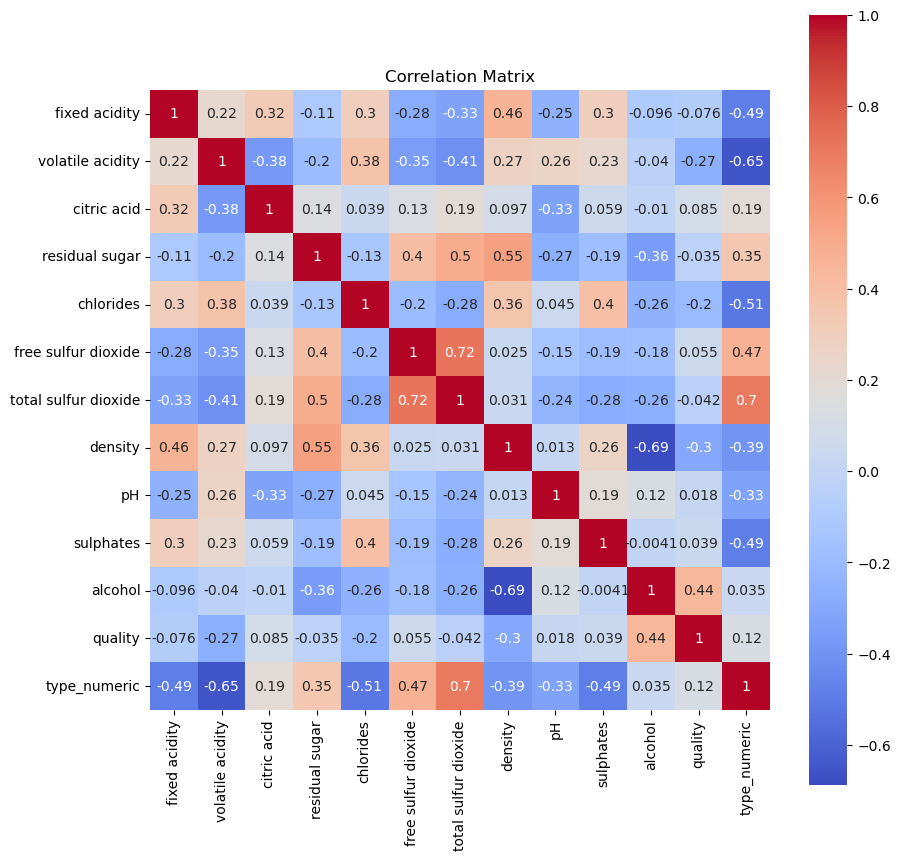

In [25]:
# Convert target to numeric labels
label_encoder = LabelEncoder()
data['type_numeric'] = label_encoder.fit_transform(data['type'])  # Add numeric labels as a new column
X = data.drop(columns=['type'])

# Calculate correlation on the DataFrame excluding the original 'type' column
correlation_matrix = data.drop(columns=['type']).corr()

# Visualize the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, square=True)
plt.title("Correlation Matrix")
plt.show()


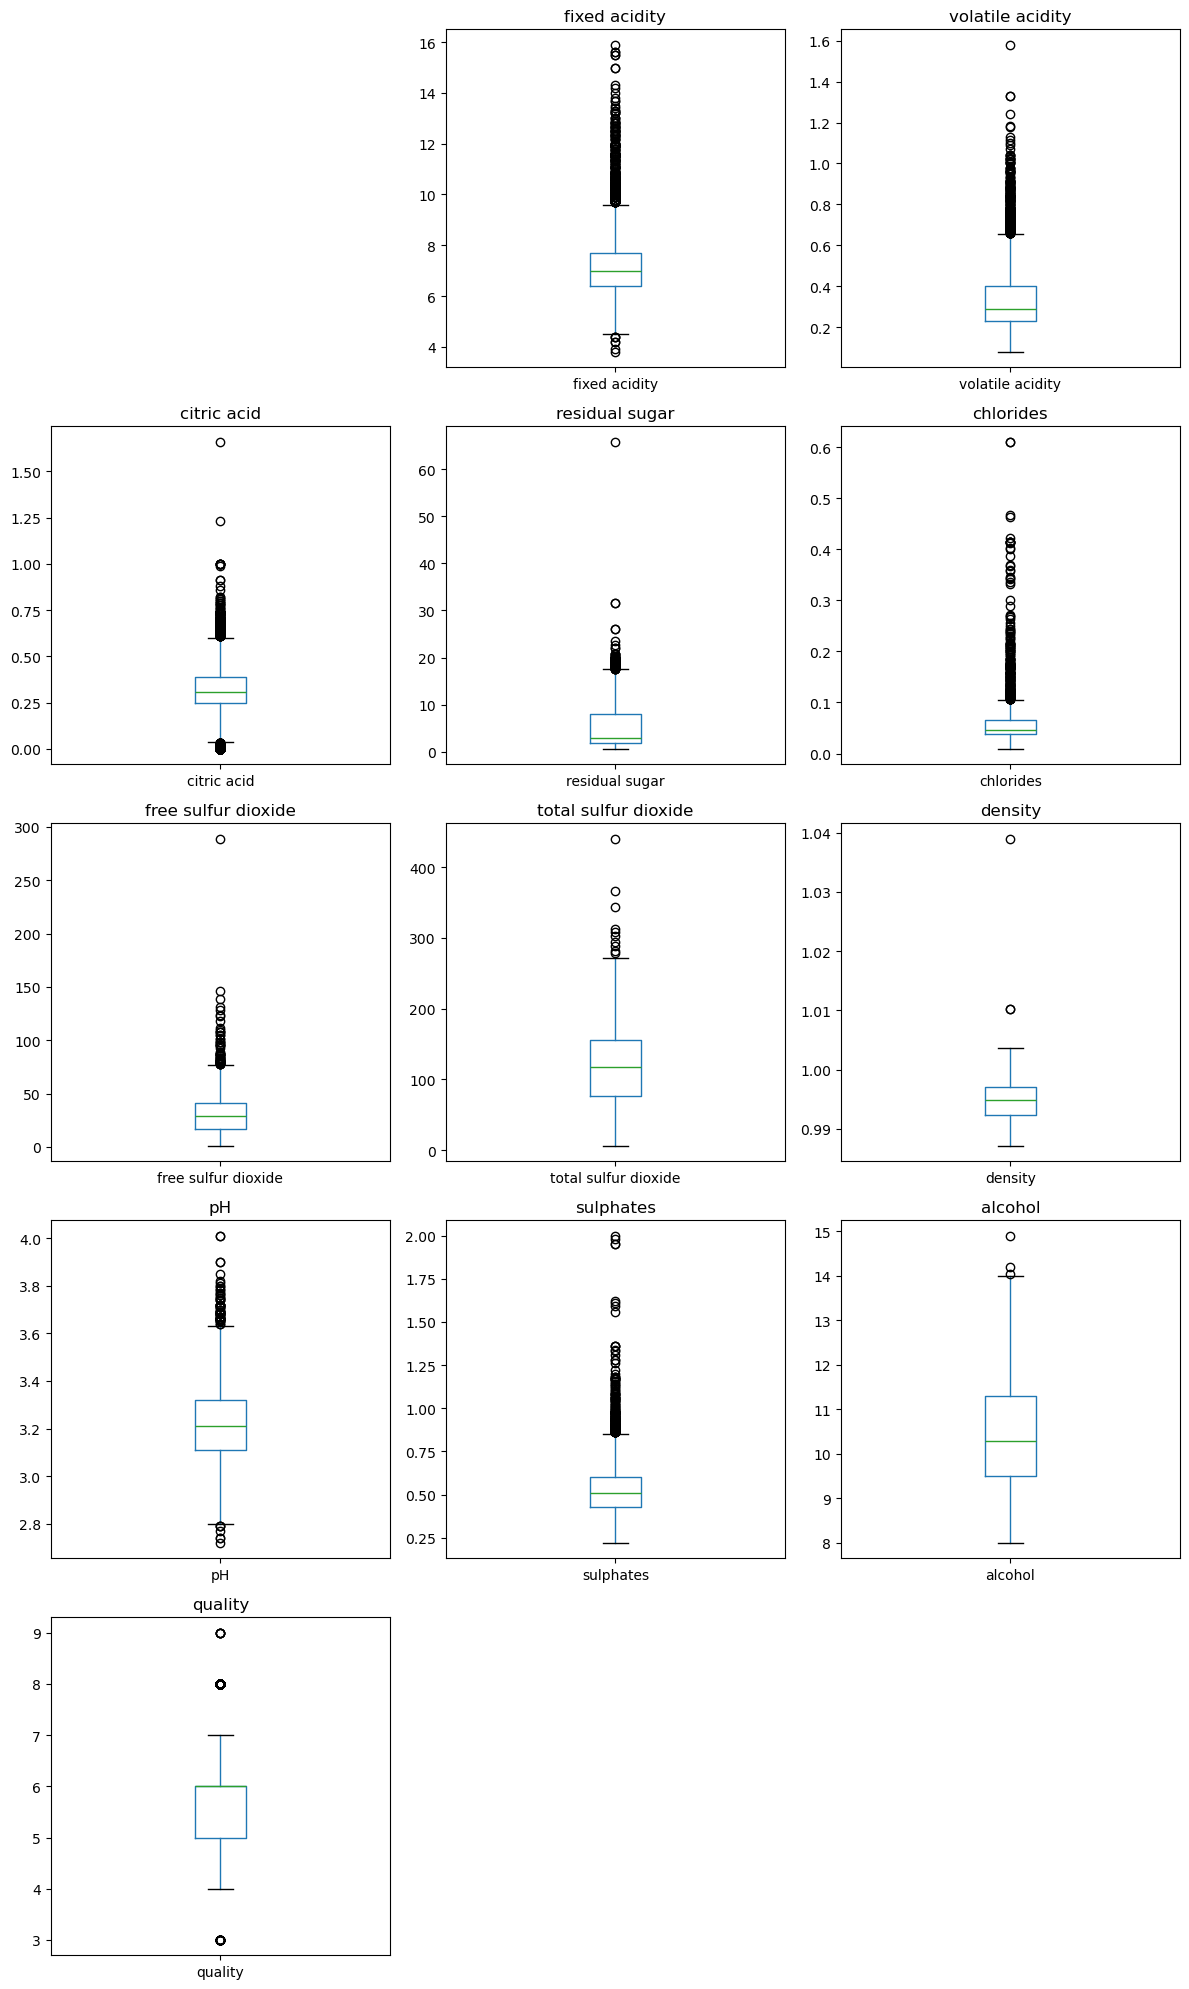

In [22]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(data.columns):
    if col != 'type':  # Skip the 'type' column if needed
        plt.subplot(5, 3, i + 1)
        data.boxplot(column=col)
        plt.title(col)
        plt.grid()

plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

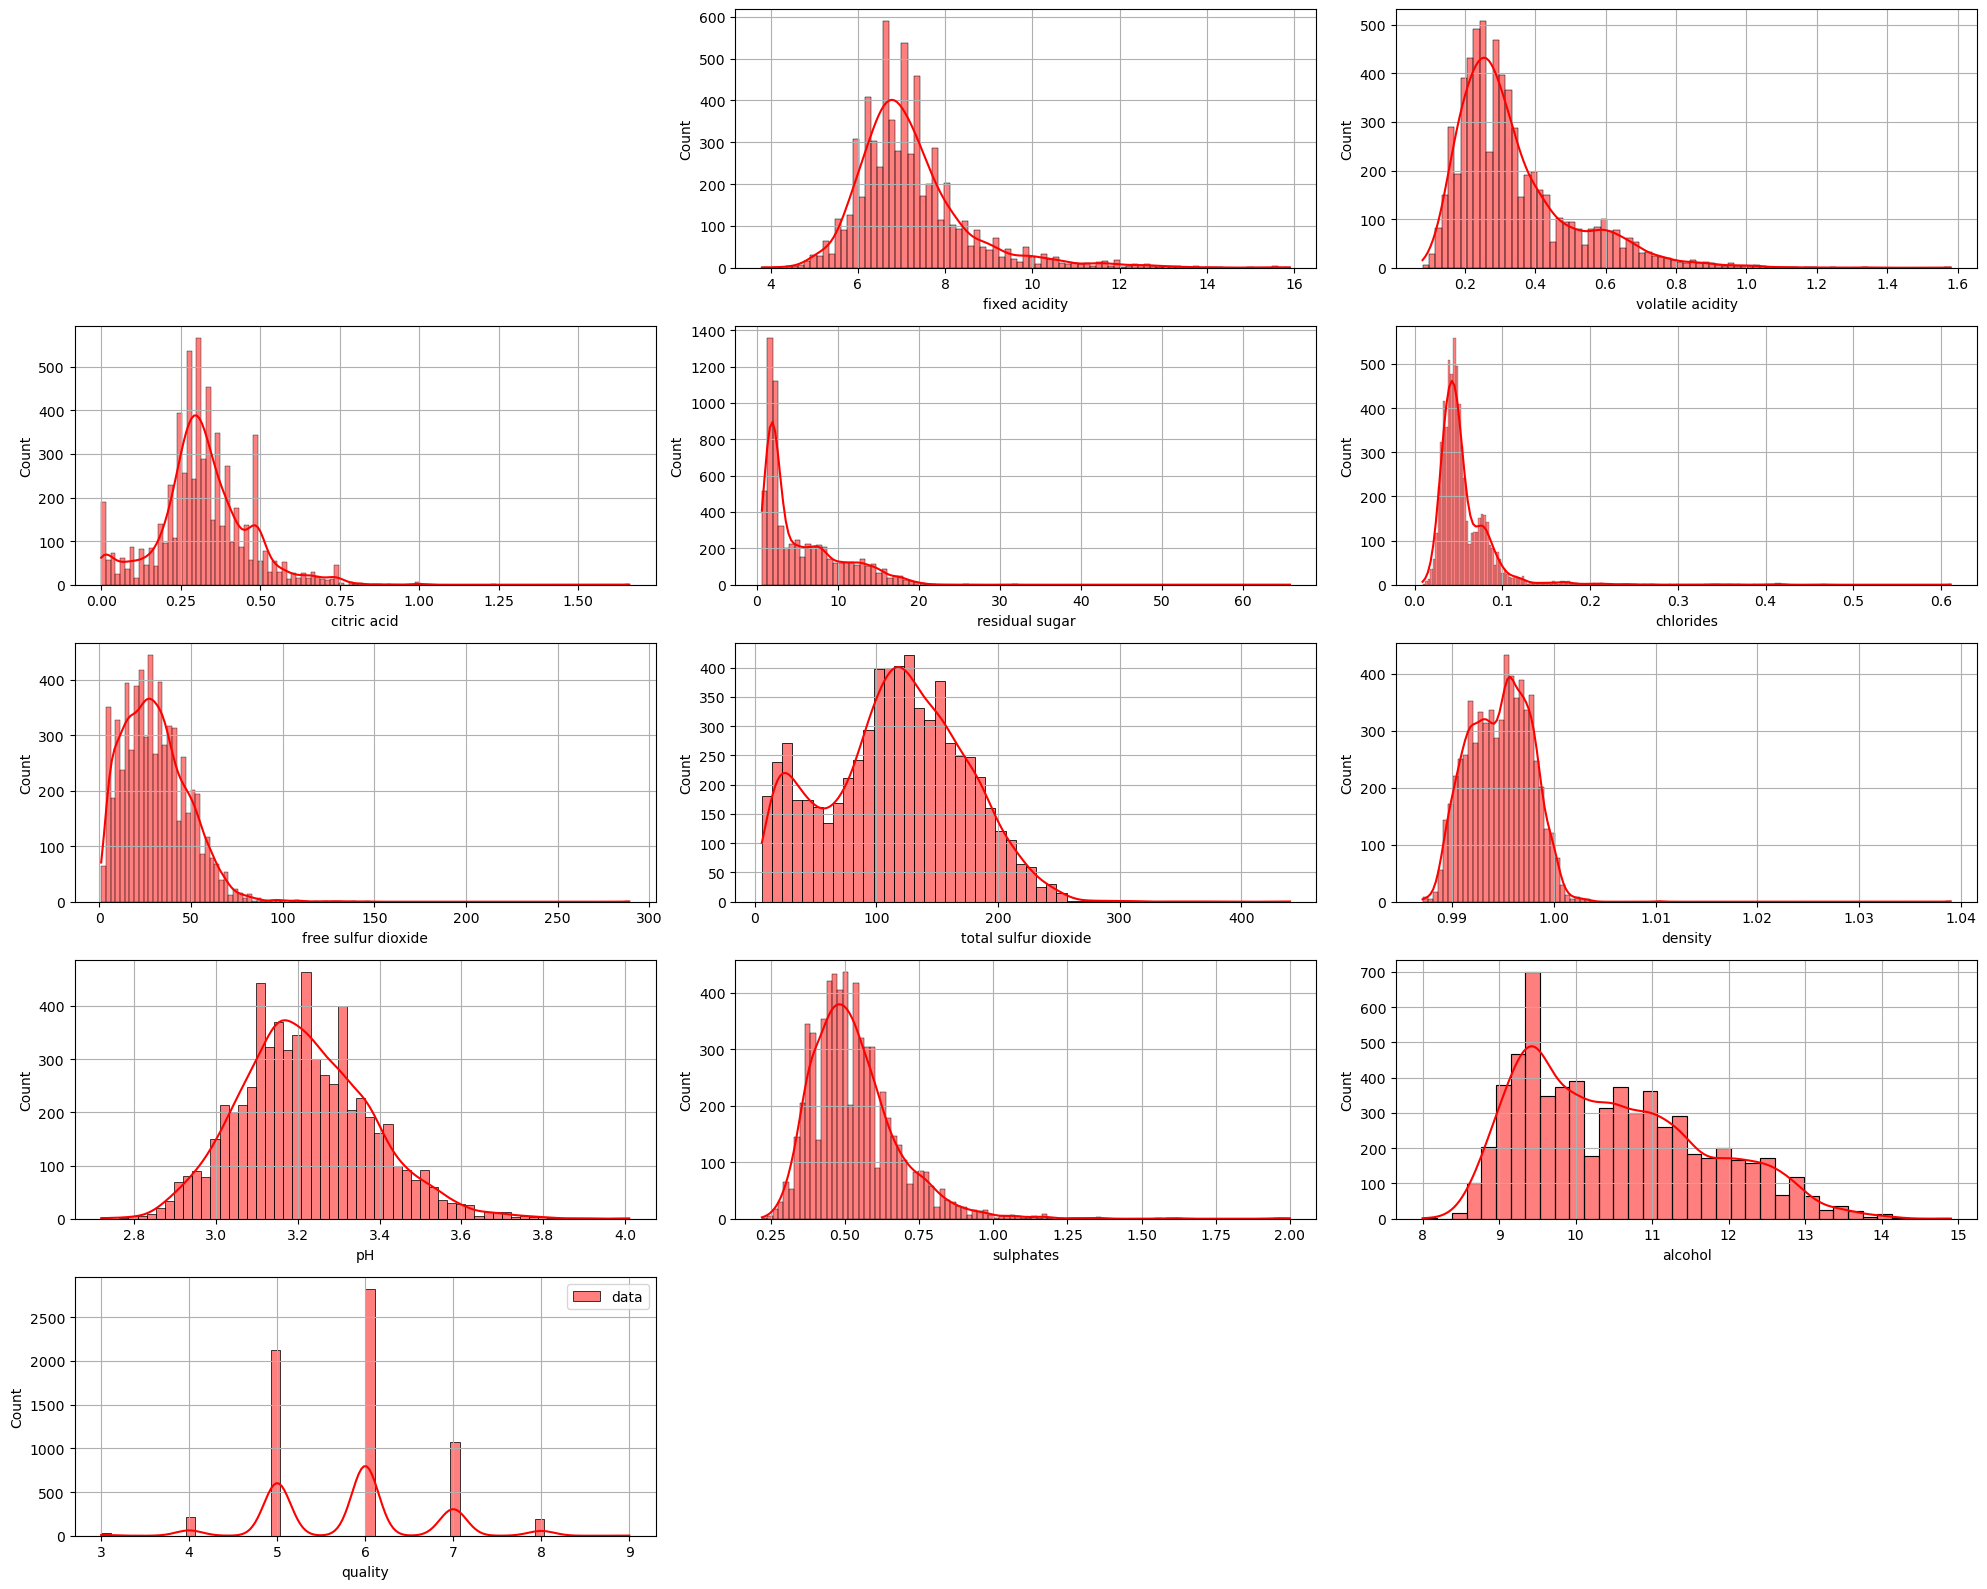

In [23]:
plt.figure(figsize=(20,16))
for i, col in enumerate(data.columns):
     if col != 'type':
        plt.subplot(5,3,i+1)
        sns.histplot(data[col],color="r", kde=True, label="data")
        plt.grid()
         
plt.legend(loc="upper right")
plt.tight_layout()

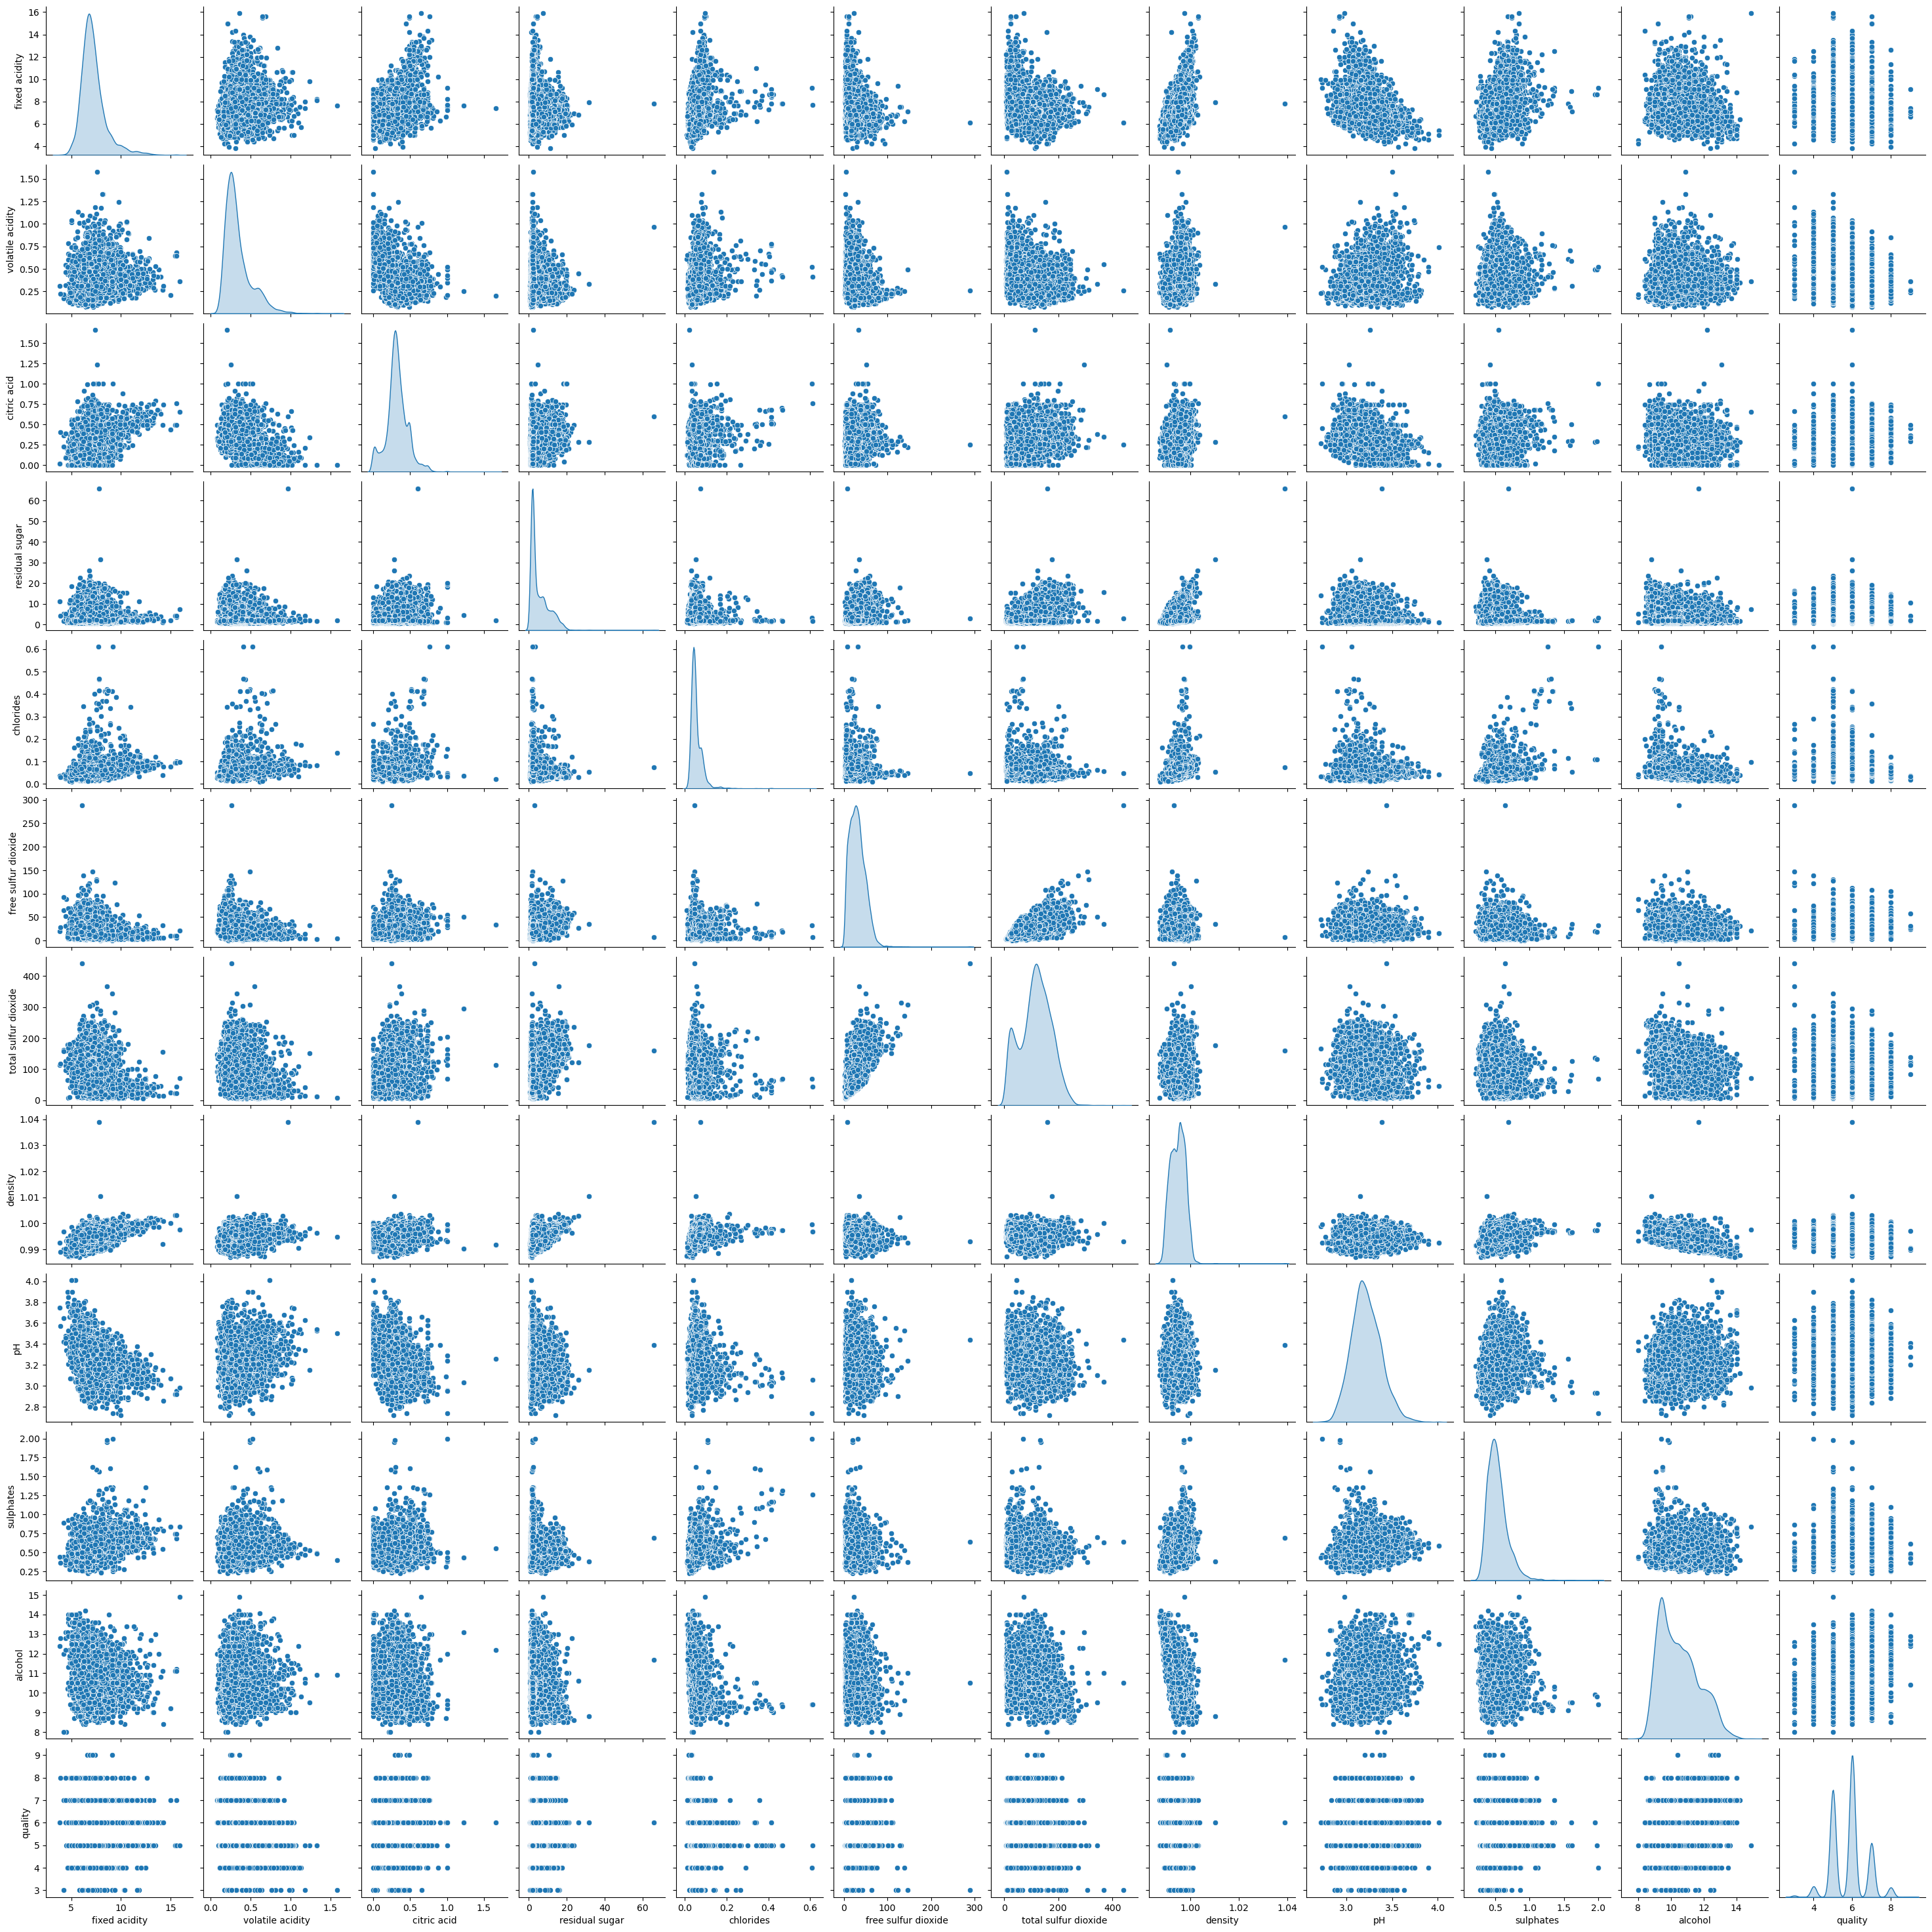

In [25]:
#to plot pairwise relationship in a data set
sns.pairplot(data=data, kind='scatter', diag_kind="kde")

APPLYING DBSCAN WITHOUT PCA

In [34]:
label_encoder = LabelEncoder()
data['type_numeric'] = label_encoder.fit_transform(data['type'])
# Prepare feature matrix X and target variable y
X = data.drop(columns=['type', 'type_numeric'])  # Drop 'quality' and the newly created 'type_numeric' column
y = data['type_numeric']  # Target variable (converted to numeric)

# Function to calculate DBSCAN evaluation metrics
def evaluate_dbscan(X_scaled, eps, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = dbscan.fit_predict(X_scaled)
    
    # Count noise points (labeled as -1)
    noise_points = (y_pred == -1).sum()
    
    # Confusion Matrix and metrics (ignore noise points which are labeled as -1)
    cm = confusion_matrix(y, y_pred, labels=np.unique(y))  # Adjust labels if necessary
    precision = precision_score(y, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y, y_pred, average='weighted', zero_division=1)
    accuracy = accuracy_score(y, y_pred)
    
    return cm, precision, recall, accuracy, noise_points, y_pred

# Function to plot DBSCAN results
def plot_dbscan(X_scaled, y_pred, title="DBSCAN Clusters"):
    pca_vis = PCA(n_components=2)
    X_vis = pca_vis.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_pred, palette='viridis', s=50)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

In [36]:
#Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

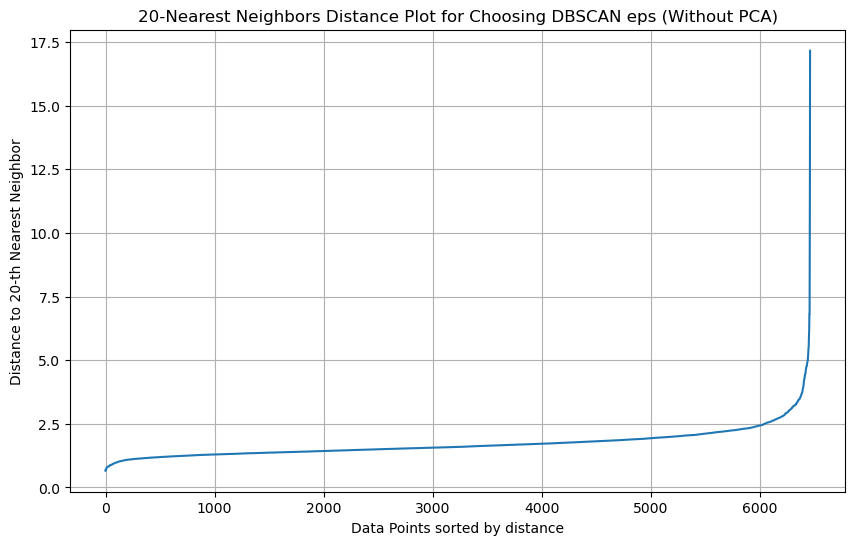

Suggested eps value (without PCA): 2.6658815392682147


In [38]:
#Apply KNN to find eps for DBSCAN without PCA
k = 20 
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, k - 1], axis=0)

# Plot the sorted k-distances
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title(f"{k}-Nearest Neighbors Distance Plot for Choosing DBSCAN eps (Without PCA)")
plt.grid()
plt.show()

# Suggest eps based on the top 10% distances
eps_suggested = np.median(distances[-len(distances) // 10:])
print(f"Suggested eps value (without PCA): {eps_suggested}")


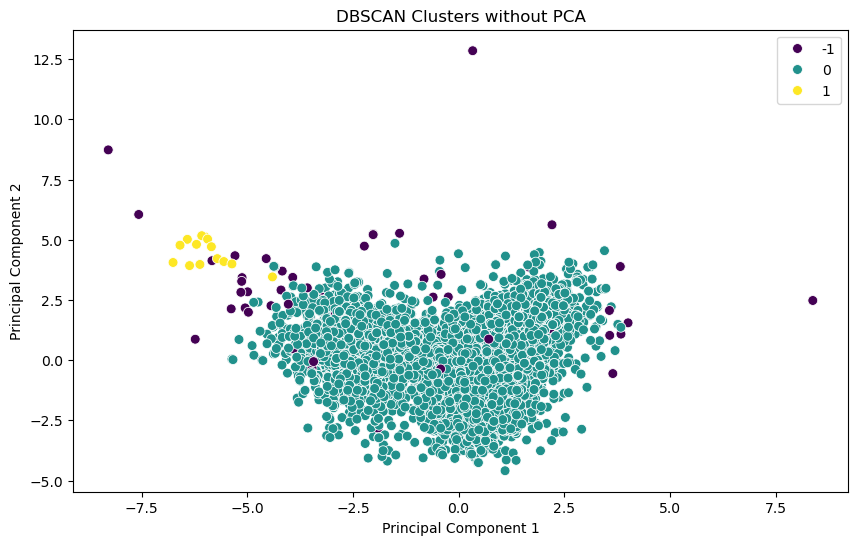

In [40]:
#Apply DBSCAN without PCA
cm_no_pca, precision_no_pca, recall_no_pca, accuracy_no_pca, noise_points_no_pca, y_pred_no_pca = evaluate_dbscan(X_scaled, eps_suggested)

# Visualize DBSCAN results (without PCA)
plot_dbscan(X_scaled, y_pred_no_pca, "DBSCAN Clusters without PCA")

APPLYING PCA FOR SELECTING TOP 5 FEATURES

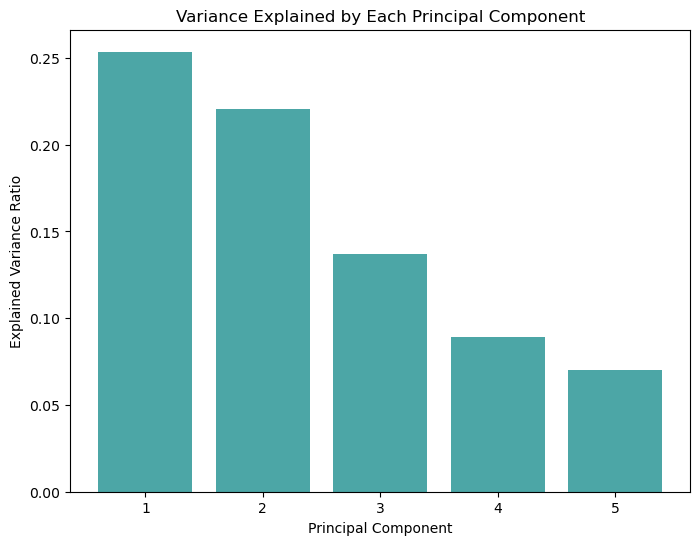

In [43]:
#Apply PCA for feature selection (reduce to 5 components)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='teal', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()


APPLYING DBSCAN WITH PCA

In [46]:
# Apply KNN to find eps for DBSCAN with PCA
nearest_neighbors_pca = NearestNeighbors(n_neighbors=k)
neighbors_pca = nearest_neighbors_pca.fit(X_pca)
distances_pca, indices_pca = neighbors_pca.kneighbors(X_pca)

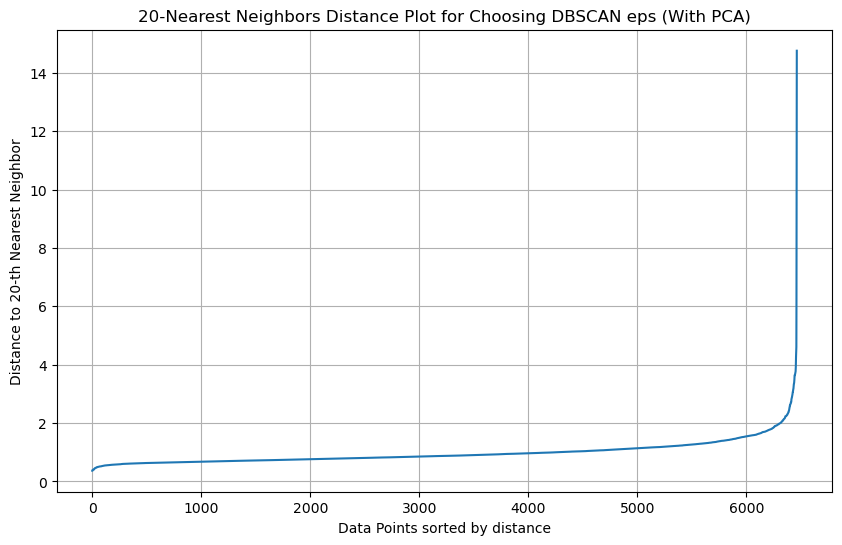

Suggested eps value (with PCA): 1.668429972116594


In [48]:
# Sort the distances to the k-th nearest neighbor
distances_pca = np.sort(distances_pca[:, k - 1], axis=0)

# Plot the sorted k-distances (with PCA)
plt.figure(figsize=(10, 6))
plt.plot(distances_pca)
plt.xlabel("Data Points sorted by distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title(f"{k}-Nearest Neighbors Distance Plot for Choosing DBSCAN eps (With PCA)")
plt.grid()
plt.show()

# Suggest eps based on the top 10% distances (with PCA)
eps_suggested_pca = np.median(distances_pca[-len(distances_pca) // 10:])
print(f"Suggested eps value (with PCA): {eps_suggested_pca}")


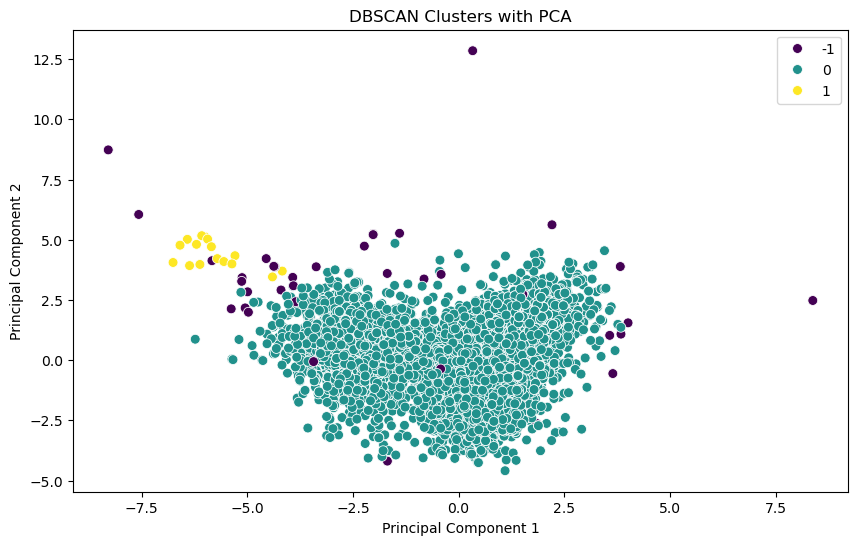

In [50]:
#Apply DBSCAN with PCA
cm_with_pca, precision_with_pca, recall_with_pca, accuracy_with_pca, noise_points_with_pca, y_pred_with_pca = evaluate_dbscan(X_pca, eps_suggested_pca)

# Visualize DBSCAN results (with PCA)
plot_dbscan(X_pca, y_pred_with_pca, "DBSCAN Clusters with PCA")

COMPARING THE RESULTS OF THE MODEL WITH AND WITHOUT PCA

In [53]:
#Compare Results in Tabular Form
results_comparison = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'Noise Points'],
    'Without PCA': [precision_no_pca, recall_no_pca, accuracy_no_pca, noise_points_no_pca],
    'With PCA': [precision_with_pca, recall_with_pca, accuracy_with_pca, noise_points_with_pca]
})

print("Comparison of DBSCAN Results with and without PCA:")
print(results_comparison)

# Determine better model
if accuracy_with_pca > accuracy_no_pca:
    print("Model with PCA performs better.")
else:
    print("Model without PCA performs better.")

Comparison of DBSCAN Results with and without PCA:
         Metric  Without PCA   With PCA
0     Precision     0.059592   0.059684
1        Recall     0.238744   0.239672
2      Accuracy     0.238744   0.239672
3  Noise Points    66.000000  49.000000
Model with PCA performs better.


COMPARE THE NUMBER OF CLUSTERS AND THE NOISE POINTS WITH AND WITHOUT PCA

In [56]:
#Show a table with the number of clusters and noise points for both models
#Number of clusters = len(set(y_pred)) - 1 (ignoring noise points)
num_clusters_no_pca = len(set(y_pred_no_pca)) - 1 if -1 in y_pred_no_pca else len(set(y_pred_no_pca))
num_clusters_with_pca = len(set(y_pred_with_pca)) - 1 if -1 in y_pred_with_pca else len(set(y_pred_with_pca))

clusters_comparison = pd.DataFrame({
    'Model': ['Without PCA', 'With PCA'],
    'Number of Clusters': [num_clusters_no_pca, num_clusters_with_pca],
    'Noise Points': [noise_points_no_pca, noise_points_with_pca]
})

print("\nClusters and Noise Points Comparison:")
print(clusters_comparison)


Clusters and Noise Points Comparison:
         Model  Number of Clusters  Noise Points
0  Without PCA                   2            66
1     With PCA                   2            49


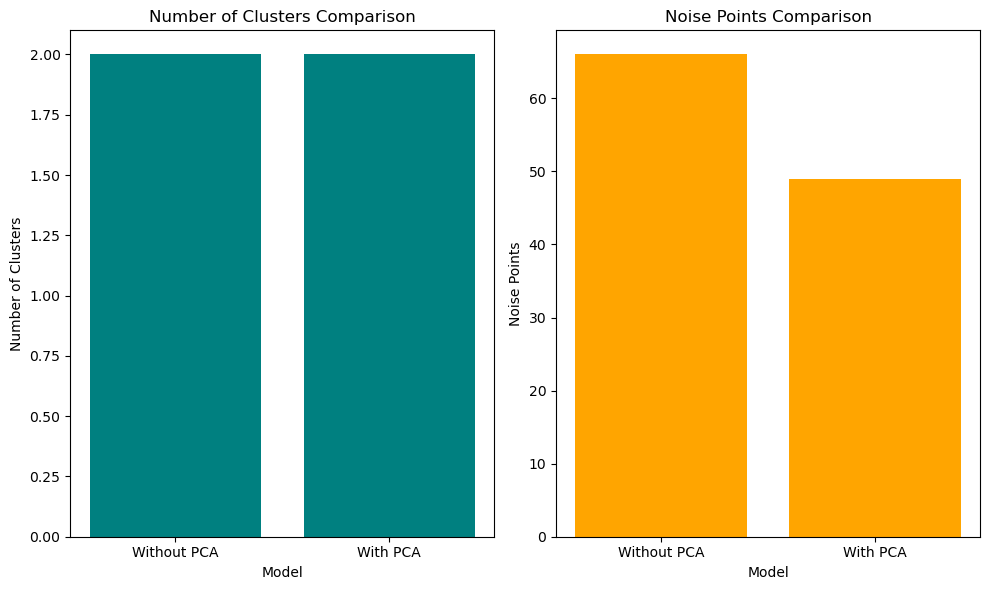

In [58]:
# Visualization for Clusters and Noise Points Comparison
plt.figure(figsize=(10, 6))

# Bar plot for the number of clusters
plt.subplot(1, 2, 1)
plt.bar(clusters_comparison['Model'], clusters_comparison['Number of Clusters'], color='teal')
plt.xlabel('Model')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters Comparison')

# Bar plot for noise points
plt.subplot(1, 2, 2)
plt.bar(clusters_comparison['Model'], clusters_comparison['Noise Points'], color='orange')
plt.xlabel('Model')
plt.ylabel('Noise Points')
plt.title('Noise Points Comparison')

plt.tight_layout()
plt.show()